Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [85]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [86]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [127]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [128]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [129]:
df.isna().sum()
df.drop(['EASE-MENT','APARTMENT_NUMBER'],inplace=True,axis=1)

In [130]:
df.head()
df.fillna(0,inplace=True)
df.isna().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.

In [131]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                   23040
unique                    120
top       2019-01-24 00:00:00
freq                      480
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [132]:
df.SALE_DATE.dt.month.value_counts()

1    6464
3    6105
2    5598
4    4873
Name: SALE_DATE, dtype: int64

In [133]:
import numpy as np
df[df['LAND_SQUARE_FEET'].isnull()]
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'], errors='coerce')
df = df.dropna(subset=['LAND_SQUARE_FEET'])
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].astype(int)

In [134]:
train = df[df['SALE_DATE'].dt.month < 4]
test = df[df['SALE_DATE'].dt.month == 4]

train.shape, test.shape

((6036, 19), (1782, 19))

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, n_jobs=-1)
train['cluster'] = kmeans.fit_predict(train[['BOROUGH', 'LOT']])
test['cluster'] = kmeans.predict(test[['BOROUGH', 'LOT']])

C:\Users\pandu\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pandu\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [137]:
train.groupby('BOROUGH').RESIDENTIAL_UNITS.mean()

BOROUGH
1    0.393609
2    0.370180
3    0.444287
4    0.190444
5    0.880435
Name: RESIDENTIAL_UNITS, dtype: float64

In [138]:
train.groupby('cluster').SALE_PRICE.describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,1594.0,1.621264e+06,7.378942e+06,0.0,67750.0,610950.0,1219137.75,239958219.0
1,3203.0,6.771326e+05,1.271938e+06,0.0,215000.0,375000.0,730000.00,27496000.0
2,36.0,8.274699e+05,1.284283e+06,0.0,0.0,162500.0,1122500.00,4800000.0
3,89.0,1.550245e+06,2.962193e+06,0.0,0.0,265000.0,1165000.00,12376829.0
4,213.0,1.590747e+06,3.469644e+06,0.0,0.0,738231.0,1595000.00,29000000.0
5,71.0,4.141322e+05,4.596327e+05,0.0,99770.0,220000.0,610950.00,1975000.0
6,4.0,2.241750e+06,7.117145e+05,1279000.0,1932250.0,2400000.0,2709500.00,2888000.0
7,650.0,2.346241e+06,1.178664e+07,0.0,10.0,750000.0,1500000.00,189109922.0
8,154.0,3.081860e+05,2.192531e+05,0.0,169250.0,275000.0,414500.00,1225000.0


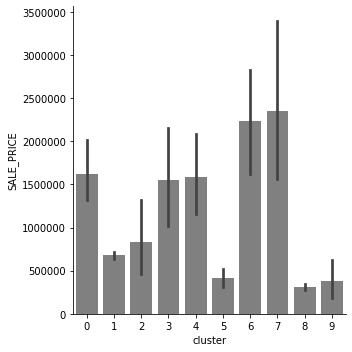

In [139]:
sns.catplot(x='cluster', y='SALE_PRICE', data=train, kind='bar', color='grey');

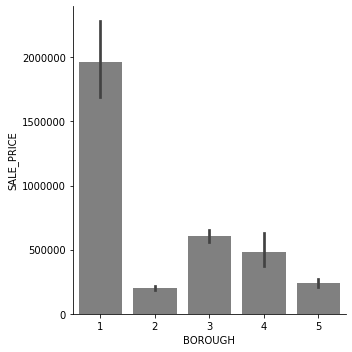

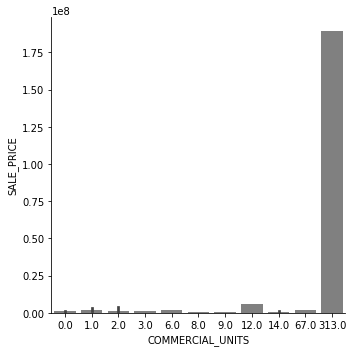

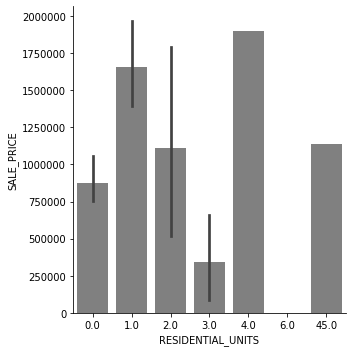

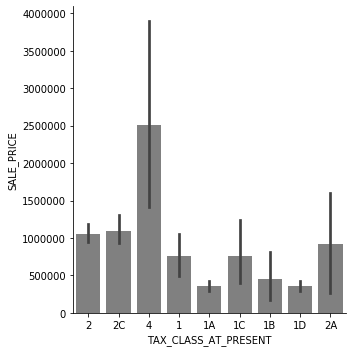

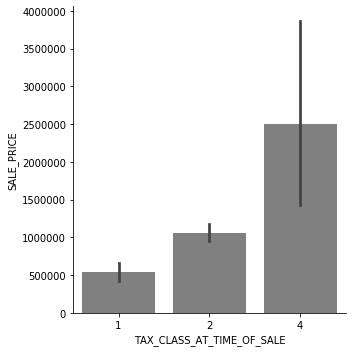

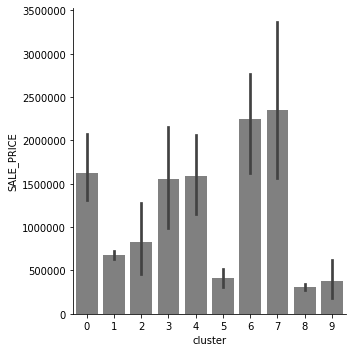

In [140]:
for col in sorted(train.columns):
    if train[col].nunique() < 12:
        sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
        plt.show()

In [141]:
train.describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,6036,6036,6036,6036,6036,6036,6036
unique,207,30,9,51,5984,51,84
top,UPPER EAST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,2,D4,262 MOTT STREET,D4,2019-02-28 00:00:00
freq,286,2686,5032,2640,3,2640,157
first,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-31 00:00:00


In [142]:
train.LAND_SQUARE_FEET.value_counts()

0      5812
153      26
500       8
850       8
900       5
       ... 
723       1
949       1
977       1
997       1
909       1
Name: LAND_SQUARE_FEET, Length: 136, dtype: int64

In [143]:
df.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                           int32
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int32
SALE_DATE                         datetime64[ns]
dtype: object

In [144]:
binary_columns = ['LAND_SQUARE_FEET']
for col in binary_columns:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

C:\Users\pandu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pandu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [145]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,2019-01-01
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,2019-01-01
14,2,MORRIS PARK/VAN NEST,29 COMMERCIAL GARAGES,4,4120,12,G7,N/A NEWPORT AVENUE,0.0,0.0,0.0,0.0,680,0.0,0.0,4,G7,0,2019-01-01
22,2,PELHAM PARKWAY SOUTH,31 COMMERCIAL VACANT LAND,4,4203,81,V1,N/A MORRIS PARK AVENUE,0.0,0.0,0.0,0.0,60,0.0,0.0,4,V1,0,2019-01-01
66,1,MIDTOWN EAST,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,D4,"345 EAST 54TH ST, 3B",10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,2019-01-02


In [146]:
df.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                           int32
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int32
SALE_DATE                         datetime64[ns]
dtype: object

In [152]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)

encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train[['BOROUGH']])

target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE','NEIGHBORHOOD','BUILDING_CLASS_AT_PRESENT','TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_CATEGORY', 'ADDRESS', 'BUILDING_CLASS_AT_TIME_OF_SALE']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]



In [148]:
encoded.head()

,BOROUGH
3,1
4,1
14,2
22,2
66,1


In [153]:
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $1,520,363 

2 features
Test MAE: $1,520,936 

3 features
Test MAE: $1,566,564 

4 features
Test MAE: $1,584,158 

5 features
Test MAE: $1,584,609 

6 features
Test MAE: $1,583,933 

7 features
Test MAE: $1,581,599 

8 features
Test MAE: $1,562,982 

9 features
Test MAE: $1,668,450 

10 features
Test MAE: $1,666,950 

11 features
Test MAE: $1,670,077 

12 features
Test MAE: $1,678,321 

